In [20]:
# load libraries
import pandas as pd
import os
import numpy as np
import datetime
# from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torch import save

In [2]:
# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change me, have to point to the Meteotrentino drive folder
wk =  "/content/drive/My Drive/10. Meteotrentino/"

# folder for the csv
subfolder = "CSVs/"

# select the filename, make me dynamic
selected_dataset = "temperature.csv"

In [21]:
# data_path = wk+subfolder+selected_dataset
data_path = "../../../temperatura2_A.csv"

In [22]:
df_row_data = pd.read_csv(
  data_path,
  sep = ";", # not a CSV, separator is ';'
  header = None, # no header
  dtype = {'0' : str, '1': str, '2': str, '3' : np.float64, '4':int} # Daniele: added the validation code so we can train on validated data (no need of classes, just distinguish between good and bad data)
  ) 



In [23]:
# define a header 
df_row_data = df_row_data.set_axis(
    ['label', 'date', 'time', 'value','validation_code'],
    axis = 1,
    inplace = False

)

In [24]:
df_row_data['datetime'] = pd.to_datetime(df_row_data['date']+" "+df_row_data['time'], format = '%d/%m/%Y %H:%M')


In [25]:
# econde the date as integer
df_row_data['datetime_enconded'] = np.int64(df_row_data['datetime'].astype(int)/10**9)
df_row_data

,label,date,time,value,validation_code,datetime,datetime_enconded
0,T0229,01/01/2014,00:00,-7.5,1,2014-01-01 00:00:00,1388534400
1,T0229,01/01/2014,00:15,-9.3,1,2014-01-01 00:15:00,1388535300
2,T0229,01/01/2014,00:30,-6.4,1,2014-01-01 00:30:00,1388536200
3,T0229,01/01/2014,00:45,-7.7,1,2014-01-01 00:45:00,1388537100
4,T0229,01/01/2014,01:00,-7.1,1,2014-01-01 01:00:00,1388538000
...,...,...,...,...,...,...,...
11606963,T0429,31/12/2021,22:45,8.0,1,2021-12-31 22:45:00,1640990700
11606964,T0429,31/12/2021,23:00,5.1,1,2021-12-31 23:00:00,1640991600
11606965,T0429,31/12/2021,23:15,3.4,1,2021-12-31 23:15:00,1640992500
11606966,T0429,31/12/2021,23:30,6.2,1,2021-12-31 23:30:00,1640993400


In [26]:
# split the dataframe by date

date_start = df_row_data['datetime'].min()

date_end = df_row_data['datetime'].max()


# period
period_split = 24 #hours

current_data = date_start

df_row_data['period_index'] = [-1]*len(df_row_data['datetime'])

i = 0
while current_data < date_end:

  offset_data = current_data+ pd.offsets.Hour(period_split)
  
  df_row_data['period_index'][(df_row_data['datetime'] < offset_data) & (df_row_data['datetime'] >= current_data)] = i

  current_data = offset_data
  i = i+1


/tmp/ipykernel_28921/1736077991.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_row_data['period_index'][(df_row_data['datetime'] < offset_data) & (df_row_data['datetime'] >= current_data)] = i


In [ ]:
df_row_data.loc[df_row_data['label']=='T0429']
print( np.unique(df_row_data['label']))

,label,date,time,value,validation_code,datetime,datetime_enconded,period_index
11326645,T0429,01/01/2014,00:00,-12.4,1,2014-01-01 00:00:00,1388534400,0
11326646,T0429,01/01/2014,00:15,-11.9,1,2014-01-01 00:15:00,1388535300,0
11326647,T0429,01/01/2014,00:30,-11.2,1,2014-01-01 00:30:00,1388536200,0
11326648,T0429,01/01/2014,00:45,-11.7,1,2014-01-01 00:45:00,1388537100,0
11326649,T0429,01/01/2014,01:00,-12.2,1,2014-01-01 01:00:00,1388538000,0
...,...,...,...,...,...,...,...,...
11606963,T0429,31/12/2021,22:45,8.0,1,2021-12-31 22:45:00,1640990700,2921
11606964,T0429,31/12/2021,23:00,5.1,1,2021-12-31 23:00:00,1640991600,2921
11606965,T0429,31/12/2021,23:15,3.4,1,2021-12-31 23:15:00,1640992500,2921
11606966,T0429,31/12/2021,23:30,6.2,1,2021-12-31 23:30:00,1640993400,2921


In [75]:
data_arr = []

for station in ['T0357']:
  df_station = df_row_data.loc[df_row_data['label']==station]
  for pk in np.unique(df_station['period_index']):
    df_subset = df_station.loc[(df_row_data['period_index'] == pk)]
    
    if df_subset.empty:
      continue

    if((df_subset['validation_code'].values != 1).any()):
      val_label = 'bad'
    else:
      val_label = 'good'

    header={
      'label':df_subset['label'].values[0],
      'in_datetime':df_subset['datetime'].values[0],
      'in_datetime_int':df_subset['datetime_enconded'].values[0],
      'val_label':val_label
    }

    features = df_subset['value'].reset_index(drop=True).to_dict()
    data_arr.append({**header,**features})
df_row_data_converted = pd.DataFrame(data_arr)
df_row_data_converted.loc[df_row_data_converted['val_label']=='bad']

T0357


,label,in_datetime,in_datetime_int,val_label,0,1,2,3,4,5,...,86,87,88,89,90,91,92,93,94,95
45,T0357,2014-02-15,1392422400,bad,-8.7,-9.1,-9.4,-9.5,-9.5,-9.4,...,-1.7,-1.7,-1.7,-1.7,-1.7,-1.7,-1.7,-1.7,-1.7,-1.7
46,T0357,2014-02-16,1392508800,bad,-1.6,-1.6,-1.6,-1.6,-1.6,-1.6,...,-1.0,-1.0,-1.1,-1.1,-1.1,-1.1,-1.1,-1.1,-1.2,-1.2
47,T0357,2014-02-17,1392595200,bad,-1.3,-1.3,-1.3,-1.3,-1.3,-1.3,...,-1.1,-1.1,-1.1,-1.2,-1.2,-1.2,-1.2,-1.2,-1.2,-1.2
48,T0357,2014-02-18,1392681600,bad,-1.2,-1.3,-1.3,-1.3,-1.3,-1.3,...,-0.9,-0.8,-0.8,-0.8,-0.7,-0.7,-0.7,-0.7,-0.7,-0.6
49,T0357,2014-02-19,1392768000,bad,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7
50,T0357,2014-02-20,1392854400,bad,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,...,-1.6,-1.7,-1.7,-1.8,-1.9,-1.9,-2.1,-2.2,-2.3,-2.4
51,T0357,2014-02-21,1392940800,bad,-2.5,-2.6,-2.7,-2.8,-2.9,-2.9,...,-2.5,-2.5,-2.5,-2.6,-2.6,-2.6,-2.6,-2.6,-2.5,-2.4
52,T0357,2014-02-22,1393027200,bad,-2.3,-2.2,-2.2,-2.2,-2.2,-2.2,...,-2.7,-2.7,-2.8,-2.9,-3.0,-3.0,-3.0,-3.1,-3.1,-3.1
53,T0357,2014-02-23,1393113600,bad,-3.2,-3.2,-3.3,-3.3,-3.4,-3.4,...,-4.0,-4.1,-4.2,-4.2,-4.2,-4.3,-4.4,-4.4,-4.5,-4.6
54,T0357,2014-02-24,1393200000,bad,-4.7,-4.7,-4.7,-4.6,-4.4,-4.3,...,-3.1,-3.2,-3.4,-3.6,-3.7,-3.5,-3.2,-2.9,-2.7,-2.5


In [341]:
import torch
# create pythorc class for the data

class CustomDataset(Dataset):
  def __init__(self, df, transform = None, target_transform = None):
    self.features = torch.FloatTensor(df.drop(['label','in_datetime','in_datetime_int','val_label'],axis=1).values)
    ### standardize the data
    mean, std= torch.mean(self.features,0), torch.std(self.features,0)
    self.features = (self.features-mean)/std

    self.label = df['label'].values
    self.in_datetime = df['in_datetime'].values
    self.in_datetime_int = df['in_datetime_int'].values
    self.val_label = df['val_label'].values
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    features = self.features[idx]
    label = self.label[idx]
    date = self.in_datetime[idx]
    val_label = self.val_label[idx]
    return {"label": label, "features": features, "val_label":val_label, "date":date}


In [377]:
# define the dataset and split in train and test
splits = ['train','test']
shuffle = {'train':True,'test':False}
dataset = {}

df_row_data_converted = df_row_data_converted.dropna().reset_index(drop=True)

good_samples = df_row_data_converted.loc[df_row_data_converted['val_label']=='good']
bad_samples = df_row_data_converted.loc[df_row_data_converted['val_label']=='bad']

# Test dataframe is made of all bad samples plus an equal number of good ones
test_part_good = good_samples.sample(n = len(bad_samples))
test = pd.concat([test_part_good, bad_samples], axis = 0)

# Train dataframe is made of all good samples 
train = good_samples.drop(test_part_good.index)

dataset['train'] = CustomDataset(train)
dataset['test'] = CustomDataset( test )
b_size = {'train':12,'test':len(dataset['test'])}

dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x)
                                            #num_workers=int(opt.workers),
                                            #drop_last=drop_last_batch[x],
                                            #worker_init_fn=(None if opt.manualseed == -1
                                            #else lambda x: np.random.seed(opt.manualseed)))
            for x in splits}




>> Training model AE_1D.


100%|██████████| 238/238 [00:00<00:00, 351.61it/s]


>> Training model AE_1D. Epoch 1/100
>> Training loss: 0.24828879535198212
>> Validation loss: 1.0299310684204102


100%|██████████| 238/238 [00:00<00:00, 454.28it/s]


>> Training model AE_1D. Epoch 2/100
>> Training loss: 1.0914562940597534
>> Validation loss: 0.8490127921104431


100%|██████████| 238/238 [00:00<00:00, 415.28it/s]


>> Training model AE_1D. Epoch 3/100
>> Training loss: 0.13324131071567535
>> Validation loss: 0.6449625492095947


100%|██████████| 238/238 [00:00<00:00, 454.80it/s]


>> Training model AE_1D. Epoch 4/100
>> Training loss: 0.23125021159648895
>> Validation loss: 0.4912521541118622


100%|██████████| 238/238 [00:00<00:00, 484.30it/s]


>> Training model AE_1D. Epoch 5/100
>> Training loss: 0.03495529666543007
>> Validation loss: 0.40298616886138916


100%|██████████| 238/238 [00:00<00:00, 473.28it/s]


>> Training model AE_1D. Epoch 6/100
>> Training loss: 0.09271296113729477
>> Validation loss: 0.3518592119216919


100%|██████████| 238/238 [00:00<00:00, 488.33it/s]


>> Training model AE_1D. Epoch 7/100
>> Training loss: 0.03252787888050079
>> Validation loss: 0.3123932480812073


100%|██████████| 238/238 [00:00<00:00, 466.10it/s]


>> Training model AE_1D. Epoch 8/100
>> Training loss: 1.221396803855896
>> Validation loss: 0.2737598717212677


100%|██████████| 238/238 [00:00<00:00, 485.99it/s]


>> Training model AE_1D. Epoch 9/100
>> Training loss: 0.8805422782897949
>> Validation loss: 0.23280324041843414


100%|██████████| 238/238 [00:00<00:00, 473.98it/s]


>> Training model AE_1D. Epoch 10/100
>> Training loss: 0.37007367610931396
>> Validation loss: 0.19097650051116943


100%|██████████| 238/238 [00:00<00:00, 501.77it/s]


>> Training model AE_1D. Epoch 11/100
>> Training loss: 0.012233011424541473
>> Validation loss: 0.1503099650144577


100%|██████████| 238/238 [00:00<00:00, 441.07it/s]


>> Training model AE_1D. Epoch 12/100
>> Training loss: 0.01253869105130434
>> Validation loss: 0.11323188245296478


100%|██████████| 238/238 [00:00<00:00, 483.96it/s]


>> Training model AE_1D. Epoch 13/100
>> Training loss: 0.01683666557073593
>> Validation loss: 0.08243478834629059


100%|██████████| 238/238 [00:00<00:00, 474.77it/s]


>> Training model AE_1D. Epoch 14/100
>> Training loss: 0.02257367968559265
>> Validation loss: 0.0596979558467865


100%|██████████| 238/238 [00:00<00:00, 463.97it/s]


>> Training model AE_1D. Epoch 15/100
>> Training loss: 0.09294396638870239
>> Validation loss: 0.04516129195690155


100%|██████████| 238/238 [00:00<00:00, 470.42it/s]


>> Training model AE_1D. Epoch 16/100
>> Training loss: 0.01788480207324028
>> Validation loss: 0.03681733459234238


100%|██████████| 238/238 [00:00<00:00, 474.99it/s]


>> Training model AE_1D. Epoch 17/100
>> Training loss: 0.1332295686006546
>> Validation loss: 0.03284193202853203


100%|██████████| 238/238 [00:00<00:00, 457.48it/s]


>> Training model AE_1D. Epoch 18/100
>> Training loss: 0.11640852689743042
>> Validation loss: 0.03065348230302334


100%|██████████| 238/238 [00:00<00:00, 459.88it/s]


>> Training model AE_1D. Epoch 19/100
>> Training loss: 0.05461544916033745
>> Validation loss: 0.029715433716773987


100%|██████████| 238/238 [00:00<00:00, 490.88it/s]


>> Training model AE_1D. Epoch 20/100
>> Training loss: 0.0970262959599495
>> Validation loss: 0.028905801475048065


100%|██████████| 238/238 [00:00<00:00, 458.62it/s]


>> Training model AE_1D. Epoch 21/100
>> Training loss: 0.01785345934331417
>> Validation loss: 0.028487280011177063


100%|██████████| 238/238 [00:00<00:00, 466.59it/s]


>> Training model AE_1D. Epoch 22/100
>> Training loss: 0.022480756044387817
>> Validation loss: 0.028023408725857735


100%|██████████| 238/238 [00:00<00:00, 438.34it/s]


>> Training model AE_1D. Epoch 23/100
>> Training loss: 0.1267763078212738
>> Validation loss: 0.027790607884526253


100%|██████████| 238/238 [00:00<00:00, 461.26it/s]


>> Training model AE_1D. Epoch 24/100
>> Training loss: 0.04448598250746727
>> Validation loss: 0.02718614786863327


100%|██████████| 238/238 [00:00<00:00, 474.79it/s]


>> Training model AE_1D. Epoch 25/100
>> Training loss: 0.06577485054731369
>> Validation loss: 0.02694467082619667


100%|██████████| 238/238 [00:00<00:00, 448.80it/s]


>> Training model AE_1D. Epoch 26/100
>> Training loss: 0.0153512479737401
>> Validation loss: 0.02624901756644249


100%|██████████| 238/238 [00:00<00:00, 480.23it/s]


>> Training model AE_1D. Epoch 27/100
>> Training loss: 0.06041628122329712
>> Validation loss: 0.02588261291384697


100%|██████████| 238/238 [00:00<00:00, 437.96it/s]


>> Training model AE_1D. Epoch 28/100
>> Training loss: 0.01384724210947752
>> Validation loss: 0.02540474198758602


100%|██████████| 238/238 [00:00<00:00, 455.95it/s]


>> Training model AE_1D. Epoch 29/100
>> Training loss: 0.03233983367681503
>> Validation loss: 0.025031136348843575


100%|██████████| 238/238 [00:00<00:00, 457.48it/s]


>> Training model AE_1D. Epoch 30/100
>> Training loss: 0.014431544579565525
>> Validation loss: 0.02443147823214531


100%|██████████| 238/238 [00:00<00:00, 467.22it/s]


>> Training model AE_1D. Epoch 31/100
>> Training loss: 0.026983624324202538
>> Validation loss: 0.023972947150468826


100%|██████████| 238/238 [00:00<00:00, 484.65it/s]


>> Training model AE_1D. Epoch 32/100
>> Training loss: 0.024828163906931877
>> Validation loss: 0.02384442463517189


100%|██████████| 238/238 [00:00<00:00, 462.25it/s]


>> Training model AE_1D. Epoch 33/100
>> Training loss: 0.07900027185678482
>> Validation loss: 0.023435592651367188


100%|██████████| 238/238 [00:00<00:00, 476.95it/s]


>> Training model AE_1D. Epoch 34/100
>> Training loss: 0.017761530354619026
>> Validation loss: 0.022587236016988754


100%|██████████| 238/238 [00:00<00:00, 484.62it/s]


>> Training model AE_1D. Epoch 35/100
>> Training loss: 0.053551819175481796
>> Validation loss: 0.021947277709841728


100%|██████████| 238/238 [00:00<00:00, 471.98it/s]


>> Training model AE_1D. Epoch 36/100
>> Training loss: 0.039311494678258896
>> Validation loss: 0.021456176415085793


100%|██████████| 238/238 [00:00<00:00, 497.61it/s]


>> Training model AE_1D. Epoch 37/100
>> Training loss: 0.020609650760889053
>> Validation loss: 0.021131014451384544


100%|██████████| 238/238 [00:00<00:00, 461.96it/s]


>> Training model AE_1D. Epoch 38/100
>> Training loss: 0.05196455121040344
>> Validation loss: 0.020900771021842957


100%|██████████| 238/238 [00:00<00:00, 485.38it/s]


>> Training model AE_1D. Epoch 39/100
>> Training loss: 0.09272265434265137
>> Validation loss: 0.02029854618012905


100%|██████████| 238/238 [00:00<00:00, 460.27it/s]


>> Training model AE_1D. Epoch 40/100
>> Training loss: 0.030715899541974068
>> Validation loss: 0.019733231514692307


100%|██████████| 238/238 [00:00<00:00, 477.13it/s]


>> Training model AE_1D. Epoch 41/100
>> Training loss: 0.010966540314257145
>> Validation loss: 0.01948419213294983


100%|██████████| 238/238 [00:00<00:00, 480.98it/s]


>> Training model AE_1D. Epoch 42/100
>> Training loss: 0.0630432665348053
>> Validation loss: 0.019099712371826172


100%|██████████| 238/238 [00:00<00:00, 500.83it/s]


>> Training model AE_1D. Epoch 43/100
>> Training loss: 0.03236917406320572
>> Validation loss: 0.018650442361831665


100%|██████████| 238/238 [00:00<00:00, 477.92it/s]


>> Training model AE_1D. Epoch 44/100
>> Training loss: 0.05036386847496033
>> Validation loss: 0.01857493631541729


100%|██████████| 238/238 [00:00<00:00, 455.39it/s]


>> Training model AE_1D. Epoch 45/100
>> Training loss: 0.037278566509485245
>> Validation loss: 0.018325408920645714


100%|██████████| 238/238 [00:00<00:00, 479.14it/s]


>> Training model AE_1D. Epoch 46/100
>> Training loss: 0.02104119025170803
>> Validation loss: 0.01775522530078888


100%|██████████| 238/238 [00:00<00:00, 418.70it/s]


>> Training model AE_1D. Epoch 47/100
>> Training loss: 0.017376704141497612
>> Validation loss: 0.017688903957605362


100%|██████████| 238/238 [00:00<00:00, 463.29it/s]


>> Training model AE_1D. Epoch 48/100
>> Training loss: 0.028042277321219444
>> Validation loss: 0.017446648329496384


100%|██████████| 238/238 [00:00<00:00, 424.60it/s]


>> Training model AE_1D. Epoch 49/100
>> Training loss: 0.05193124711513519
>> Validation loss: 0.017228860408067703


100%|██████████| 238/238 [00:00<00:00, 485.24it/s]


>> Training model AE_1D. Epoch 50/100
>> Training loss: 0.05511033162474632
>> Validation loss: 0.01681818626821041


100%|██████████| 238/238 [00:00<00:00, 473.65it/s]


>> Training model AE_1D. Epoch 51/100
>> Training loss: 0.0153553681448102
>> Validation loss: 0.016361577436327934


100%|██████████| 238/238 [00:00<00:00, 475.17it/s]


>> Training model AE_1D. Epoch 52/100
>> Training loss: 0.04545186087489128
>> Validation loss: 0.016450079157948494


100%|██████████| 238/238 [00:00<00:00, 473.64it/s]


>> Training model AE_1D. Epoch 53/100
>> Training loss: 0.006516279187053442
>> Validation loss: 0.015890056267380714


100%|██████████| 238/238 [00:00<00:00, 471.29it/s]


>> Training model AE_1D. Epoch 54/100
>> Training loss: 0.012313802726566792
>> Validation loss: 0.01570717617869377


100%|██████████| 238/238 [00:00<00:00, 478.71it/s]


>> Training model AE_1D. Epoch 55/100
>> Training loss: 0.060966312885284424
>> Validation loss: 0.015377435833215714


100%|██████████| 238/238 [00:00<00:00, 447.49it/s]


>> Training model AE_1D. Epoch 56/100
>> Training loss: 0.019317183643579483
>> Validation loss: 0.015586620196700096


100%|██████████| 238/238 [00:00<00:00, 468.90it/s]


>> Training model AE_1D. Epoch 57/100
>> Training loss: 0.04999774321913719
>> Validation loss: 0.01524471864104271


100%|██████████| 238/238 [00:00<00:00, 479.21it/s]


>> Training model AE_1D. Epoch 58/100
>> Training loss: 0.07136982679367065
>> Validation loss: 0.014749819412827492


100%|██████████| 238/238 [00:00<00:00, 486.74it/s]


>> Training model AE_1D. Epoch 59/100
>> Training loss: 0.024716360494494438
>> Validation loss: 0.014618663117289543


100%|██████████| 238/238 [00:00<00:00, 451.27it/s]


>> Training model AE_1D. Epoch 60/100
>> Training loss: 0.06824035197496414
>> Validation loss: 0.0140739930793643


100%|██████████| 238/238 [00:00<00:00, 480.43it/s]


>> Training model AE_1D. Epoch 61/100
>> Training loss: 0.02054685540497303
>> Validation loss: 0.0140854986384511


100%|██████████| 238/238 [00:00<00:00, 486.86it/s]


>> Training model AE_1D. Epoch 62/100
>> Training loss: 0.028709910809993744
>> Validation loss: 0.01414787769317627


100%|██████████| 238/238 [00:00<00:00, 470.79it/s]


>> Training model AE_1D. Epoch 63/100
>> Training loss: 0.05096213519573212
>> Validation loss: 0.013725535944104195


100%|██████████| 238/238 [00:00<00:00, 502.86it/s]


>> Training model AE_1D. Epoch 64/100
>> Training loss: 0.0981752872467041
>> Validation loss: 0.0135370884090662


100%|██████████| 238/238 [00:00<00:00, 449.80it/s]


>> Training model AE_1D. Epoch 65/100
>> Training loss: 0.07523511350154877
>> Validation loss: 0.01348778698593378


100%|██████████| 238/238 [00:00<00:00, 492.33it/s]


>> Training model AE_1D. Epoch 66/100
>> Training loss: 0.00818711705505848
>> Validation loss: 0.013045988976955414


100%|██████████| 238/238 [00:00<00:00, 427.07it/s]


>> Training model AE_1D. Epoch 67/100
>> Training loss: 0.01815004087984562
>> Validation loss: 0.012859836220741272


100%|██████████| 238/238 [00:00<00:00, 450.63it/s]


>> Training model AE_1D. Epoch 68/100
>> Training loss: 0.03813746199011803
>> Validation loss: 0.01283668540418148


100%|██████████| 238/238 [00:00<00:00, 498.99it/s]


>> Training model AE_1D. Epoch 69/100
>> Training loss: 0.007307225838303566
>> Validation loss: 0.012580185197293758


100%|██████████| 238/238 [00:00<00:00, 454.43it/s]


>> Training model AE_1D. Epoch 70/100
>> Training loss: 0.01978284679353237
>> Validation loss: 0.012515399605035782


100%|██████████| 238/238 [00:00<00:00, 502.53it/s]


>> Training model AE_1D. Epoch 71/100
>> Training loss: 0.03927352651953697
>> Validation loss: 0.012200228869915009


100%|██████████| 238/238 [00:00<00:00, 449.77it/s]


>> Training model AE_1D. Epoch 72/100
>> Training loss: 0.05174094811081886
>> Validation loss: 0.012083426117897034


100%|██████████| 238/238 [00:00<00:00, 492.23it/s]


>> Training model AE_1D. Epoch 73/100
>> Training loss: 0.029674209654331207
>> Validation loss: 0.011919950135052204


100%|██████████| 238/238 [00:00<00:00, 496.47it/s]


>> Training model AE_1D. Epoch 74/100
>> Training loss: 0.010117586702108383
>> Validation loss: 0.011711189523339272


100%|██████████| 238/238 [00:00<00:00, 460.27it/s]


>> Training model AE_1D. Epoch 75/100
>> Training loss: 0.01415294874459505
>> Validation loss: 0.011581601575016975


100%|██████████| 238/238 [00:00<00:00, 474.50it/s]


>> Training model AE_1D. Epoch 76/100
>> Training loss: 0.01117552537471056
>> Validation loss: 0.011448778212070465


100%|██████████| 238/238 [00:00<00:00, 444.90it/s]


>> Training model AE_1D. Epoch 77/100
>> Training loss: 0.03495776653289795
>> Validation loss: 0.011210200376808643


100%|██████████| 238/238 [00:00<00:00, 489.84it/s]


>> Training model AE_1D. Epoch 78/100
>> Training loss: 0.012411460280418396
>> Validation loss: 0.010952983982861042


100%|██████████| 238/238 [00:00<00:00, 451.90it/s]


>> Training model AE_1D. Epoch 79/100
>> Training loss: 0.09934625029563904
>> Validation loss: 0.010742701590061188


100%|██████████| 238/238 [00:00<00:00, 447.07it/s]


>> Training model AE_1D. Epoch 80/100
>> Training loss: 0.027872517704963684
>> Validation loss: 0.010714122094213963


100%|██████████| 238/238 [00:00<00:00, 436.85it/s]


>> Training model AE_1D. Epoch 81/100
>> Training loss: 0.13539211452007294
>> Validation loss: 0.010411052964627743


100%|██████████| 238/238 [00:00<00:00, 487.56it/s]


>> Training model AE_1D. Epoch 82/100
>> Training loss: 0.006797491107136011
>> Validation loss: 0.010235413908958435


100%|██████████| 238/238 [00:00<00:00, 497.22it/s]


>> Training model AE_1D. Epoch 83/100
>> Training loss: 0.016827821731567383
>> Validation loss: 0.010258708149194717


100%|██████████| 238/238 [00:00<00:00, 464.52it/s]


>> Training model AE_1D. Epoch 84/100
>> Training loss: 0.0051828534342348576
>> Validation loss: 0.010030730627477169


100%|██████████| 238/238 [00:00<00:00, 465.73it/s]


>> Training model AE_1D. Epoch 85/100
>> Training loss: 0.03630589693784714
>> Validation loss: 0.009883840568363667


100%|██████████| 238/238 [00:00<00:00, 490.60it/s]


>> Training model AE_1D. Epoch 86/100
>> Training loss: 0.005673456937074661
>> Validation loss: 0.009467219933867455


100%|██████████| 238/238 [00:00<00:00, 458.54it/s]


>> Training model AE_1D. Epoch 87/100
>> Training loss: 0.010422813706099987
>> Validation loss: 0.009280828759074211


100%|██████████| 238/238 [00:00<00:00, 434.44it/s]


>> Training model AE_1D. Epoch 88/100
>> Training loss: 0.012823258526623249
>> Validation loss: 0.009172082878649235


100%|██████████| 238/238 [00:00<00:00, 498.78it/s]


>> Training model AE_1D. Epoch 89/100
>> Training loss: 0.007424740586429834
>> Validation loss: 0.009008432738482952


100%|██████████| 238/238 [00:00<00:00, 479.72it/s]


>> Training model AE_1D. Epoch 90/100
>> Training loss: 0.009938309900462627
>> Validation loss: 0.008840187452733517


100%|██████████| 238/238 [00:00<00:00, 498.67it/s]


>> Training model AE_1D. Epoch 91/100
>> Training loss: 0.028314704075455666
>> Validation loss: 0.008638396859169006


100%|██████████| 238/238 [00:00<00:00, 442.62it/s]


>> Training model AE_1D. Epoch 92/100
>> Training loss: 0.004889167845249176
>> Validation loss: 0.008355841040611267


100%|██████████| 238/238 [00:00<00:00, 479.22it/s]


>> Training model AE_1D. Epoch 93/100
>> Training loss: 0.03326931968331337
>> Validation loss: 0.008328030817210674


100%|██████████| 238/238 [00:00<00:00, 441.63it/s]


>> Training model AE_1D. Epoch 94/100
>> Training loss: 0.01200619712471962
>> Validation loss: 0.008090746589004993


100%|██████████| 238/238 [00:00<00:00, 467.04it/s]


>> Training model AE_1D. Epoch 95/100
>> Training loss: 0.05511453375220299
>> Validation loss: 0.00812144111841917


100%|██████████| 238/238 [00:00<00:00, 484.19it/s]


>> Training model AE_1D. Epoch 96/100
>> Training loss: 0.005117896944284439
>> Validation loss: 0.007903802208602428


100%|██████████| 238/238 [00:00<00:00, 467.07it/s]


>> Training model AE_1D. Epoch 97/100
>> Training loss: 0.012657876126468182
>> Validation loss: 0.007797053083777428


100%|██████████| 238/238 [00:00<00:00, 497.38it/s]


>> Training model AE_1D. Epoch 98/100
>> Training loss: 0.020055027678608894
>> Validation loss: 0.007506189867854118


100%|██████████| 238/238 [00:00<00:00, 412.42it/s]


>> Training model AE_1D. Epoch 99/100
>> Training loss: 0.043969396501779556
>> Validation loss: 0.0072409287095069885


100%|██████████| 238/238 [00:00<00:00, 480.38it/s]


>> Training model AE_1D. Epoch 100/100
>> Training loss: 0.019013315439224243
>> Validation loss: 0.007390656974166632
>> Training model AE_1D.[Done]


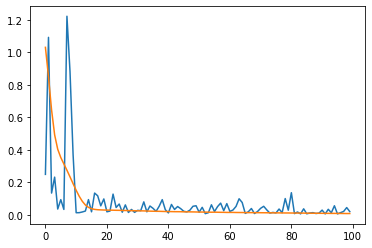

In [422]:
from importlib import reload  # Python 3.4+
model_simpleAE = reload(model_simpleAE)
from model_simpleAE import AE_1D
from options import Options

class configuration(object):
      
    def __init__(self, my_dict):
          
        for key in my_dict:
            setattr(self, key, my_dict[key])

# LOAD MODEL
opt_dict = {
    'batchsize': 12,
    'isize': 96,
    'lsize':15, 
    'device': 'cpu',
    'name': 'try1',
    'outf': './output', 
    'phase': 'train',
    'iter': 0, 
    'niter': 100,
    'lr': 1e-5, 
}

opt = configuration(opt_dict)
opt.isTrain = True

model = AE_1D(opt, dataloader)
##
# TRAIN MODEL
metrics = model.train()

metrics = pd.DataFrame(metrics)
import matplotlib.pyplot as plt
plt.plot(metrics['loss_tr'])
plt.plot(metrics['loss_val'])

bad


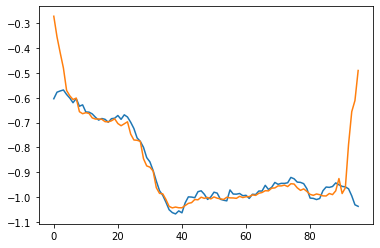

In [428]:
sample = next(iter(dataloader['train']))
sample_tensor = sample[-2]['features']
sample_validation = sample[-2]['val_label']
model.ae.eval()
with torch.no_grad():
    reconstructed = model.ae(torch.unsqueeze(sample_tensor,0))

print(sample_validation)
plt.plot(sample_tensor)
plt.plot(reconstructed[0])
plt.show()

In [ ]:
# save the classes in the typical pytorch class format

for i, class_d in enumerate(data_class_arr):
  
  save(class_d, wk + subfolder + "split_by_period/"+str(period_split)+"h/"+str(selected_dataset[:-4])+"/split_"+str(i)+".pt")
